# Installing dependencies

In [42]:
! pip install livelossplot

In [13]:
import pandas as pd
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [6]:
#Code to keep colab running
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);

# Preparation

## Prepare Covid-Net dataset

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
!unzip -qq drive/My\ Drive/data_balanced.zip

KeyboardInterrupt: ignored

# Importing data

In [1]:
import pandas as pd
from keras.utils import to_categorical
import numpy as np

np.random.seed(7)

train_data = pd.read_csv('drive/My Drive/filesAAII/train_split_v3_augmented.csv', sep=',', index_col=0)
print(train_data.head())


test_data = pd.read_csv('drive/My Drive/filesAAII/test_split_v3.txt', header=None, sep=' ', names=['id','image', 'result', 'type1', 'type2'])
test_data.head(1)


image_height = 299
image_width = 299

Using TensorFlow backend.


                                     id  ... type2
0  21e403ae-139b-4419-b3fa-0bf13d97d245  ...   NaN
1  5458205b-c67a-44de-a1e3-009f977b4f98  ...   NaN
2  4769fa12-e694-48ce-ad4e-0628e5dd75f0  ...   NaN
3  c8b05677-ce24-4967-a152-3602c5332c4c  ...   NaN
4  d8fe9c83-74df-4ca8-8075-012b6f1076bc  ...   NaN

[5 rows x 5 columns]


In [10]:
print(train_data['result'].unique())
train_data[train_data['result'] == 'COVID-19'].count()

['normal' 'pneumonia' 'COVID-19']


id         223
image     1561
result    1561
type1      196
type2       27
dtype: int64

In [11]:
print(test_data['result'].unique())
test_data[test_data['result'] == 'COVID-19'].count()

['pneumonia' 'COVID-19' 'normal']


id        31
image     31
result    31
type1     31
type2      8
dtype: int64

In [3]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32 #10

train_generator = ImageDataGenerator(
    rescale=1/255
)

test_generator = ImageDataGenerator(
    rescale=1/255
)

train_set = train_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col='image',
    directory="train/",
    y_col='result',
    shuffle=True,
    target_size=(image_width, image_height),
    batch_size = batch_size,
    class_mode='categorical'
)

test_set = test_generator.flow_from_dataframe(
    dataframe=test_data,
    x_col='image',
    directory="test/",
    y_col='result',
    shuffle=False,
    target_size=(image_width, image_height),
    batch_size = batch_size,
    class_mode='categorical'
)

Found 4961 validated image filenames belonging to 3 classes.
Found 1510 validated image filenames belonging to 3 classes.


## Analysing Data

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)


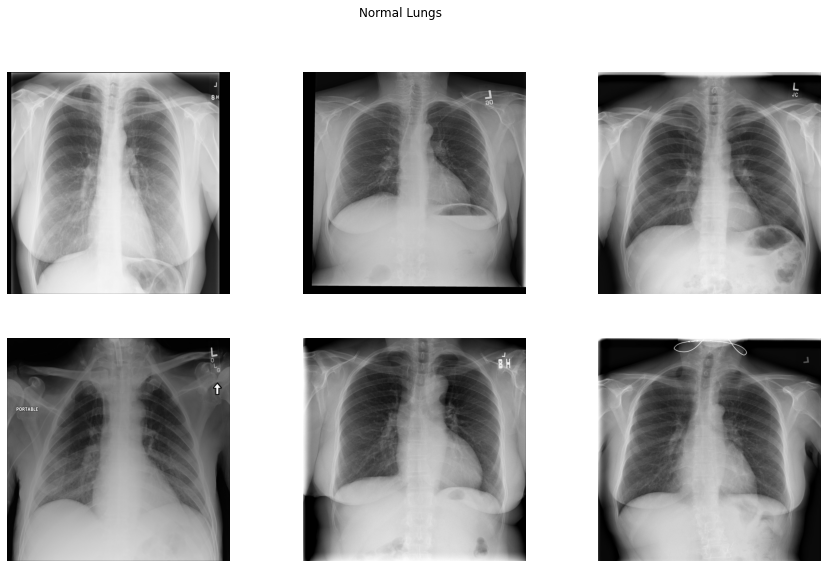

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

import cv2

f,ax = plt.subplots(2,3,figsize=(15,9))
samples_normal = train_data[train_data['result'] == 'normal']['image']

for i in range(0,6):
  im = cv2.imread('train/' + samples_normal.iloc[i])
  print(im.shape)
  ax[i//3,i%3].imshow(im)
  ax[i//3,i%3].axis('off')
f.suptitle('Normal Lungs')
plt.show()

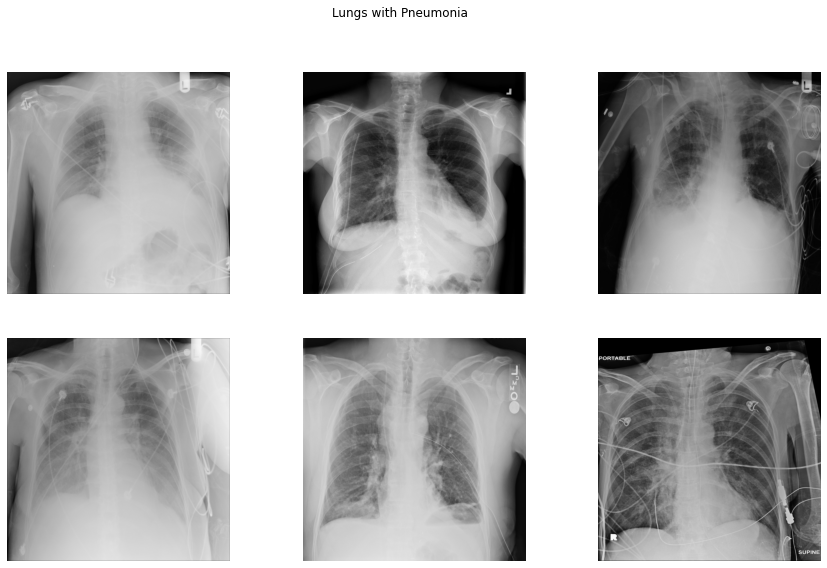

In [14]:
f,ax = plt.subplots(2,3,figsize=(15,9))
samples_normal = train_data[train_data['result'] == 'pneumonia']['image']

for i in range(0,6):
  im = cv2.imread('train/' + samples_normal.iloc[i])
  ax[i//3,i%3].imshow(im)
  ax[i//3,i%3].axis('off')
f.suptitle('Lungs with Pneumonia')
plt.show()

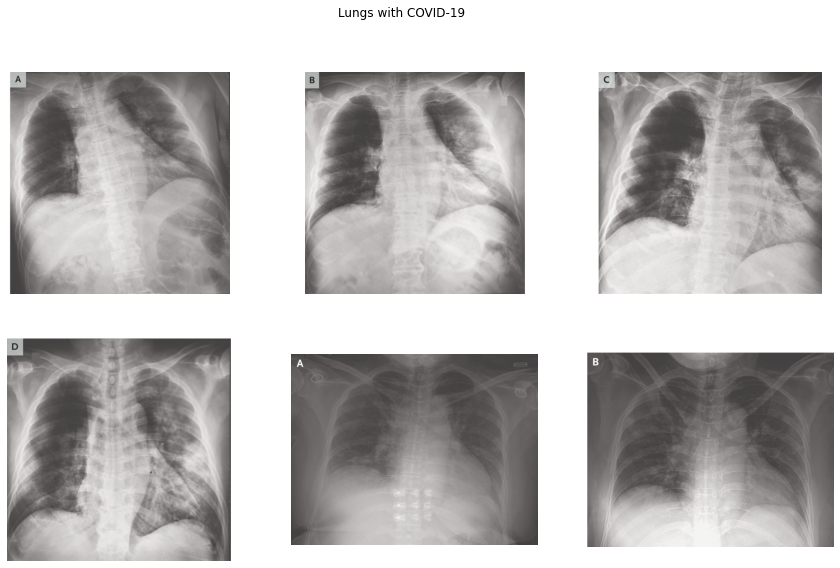

In [15]:
f,ax = plt.subplots(2,3,figsize=(15,9))
samples_normal = train_data[train_data['result'] == 'COVID-19']['image']

for i in range(0,6):
  im = cv2.imread('train/' + samples_normal.iloc[i])
  ax[i//3,i%3].imshow(im)
  ax[i//3,i%3].axis('off')
f.suptitle('Lungs with COVID-19')
plt.show()

<Figure size 432x288 with 0 Axes>

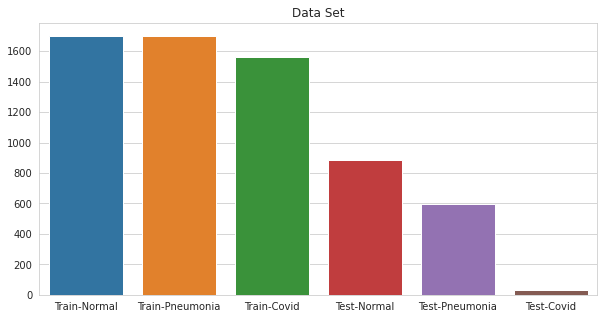

In [16]:
sns.set_style('whitegrid')
plt.figure()
plt.subplots(figsize=(10,5))
grafico=sns.barplot(x=['Train-Normal','Train-Pneumonia','Train-Covid','Test-Normal','Test-Pneumonia','Test-Covid'],
                    y=[train_data[train_data['result'] == 'normal'].shape[0],
                       train_data[train_data['result'] == 'pneumonia'].shape[0],
                       train_data[train_data['result'] == 'COVID-19'].shape[0],
                       test_data[test_data['result'] == 'normal'].shape[0],
                       test_data[test_data['result'] == 'pneumonia'].shape[0],
                       test_data[test_data['result'] == 'COVID-19'].shape[0]
                    ]) 
grafico.set_title('Data Set')
plt.show()

# Developing model

## Auxiliary Functions

In [5]:
import os

def save_model_on_cloud(model,name,ind):
  path="/content/drive/My Drive/covid_runs/run"+ind
  os.makedirs(path)
  model.save_weights(path + "/last_run" + name + ".hdf5")
  json_model = model.to_json()
  with open(path + "/" + name + ".json", "w") as json_file:
    json_file.write(model_json)
  os.rename("best_weights_" + name + ".hdf5", path + "/best_weights_" + name + ".hdf5")

In [6]:
from keras.models import model_from_json
import json

def load_model_from_cloud(model_path, weights_path):
  with open(model_path, 'r') as json_file:
    architecture  = json.load(json_file)
    model = model_from_json(json.dumps(architecture))
  model.load_weights(weights_path)
  return model

In [7]:
import cv2
def query_model(model, img):
  tmp_image = cv2.imread(img)
  tmp_image = np.array(tmp_image)
  tmp_image = cv2.resize(tmp_image, (image_width, image_height))
  tmp_image = tmp_image / 255
  res = model.predict(np.expand_dims(tmp_image, axis=0))
  print(test_set.class_indices)
  ind = np.argmax(res)
  print(ind)
  print([t * 100 for t in res])

## Importing pre-trained model -> XCeption

#### XCeption 1

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
import keras
from keras.models import Model
from keras.optimizers import Adam

image_height = 299
image_width = 299


xception = keras.applications.Xception(weights='imagenet',include_top=False, input_shape = (image_width, image_height, 3))

for layer in xception.layers:
    layer.trainable = False

new_model = xception.output
new_model = GlobalAveragePooling2D()(new_model)
new_model = Dense(3, activation="softmax")(new_model)

final_Model = Model(inputs=xception.input, outputs=new_model)




opt = Adam(learning_rate=0.0001)
final_Model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


final_Model.summary()

83689472/83683744 [==============================] - 3s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________

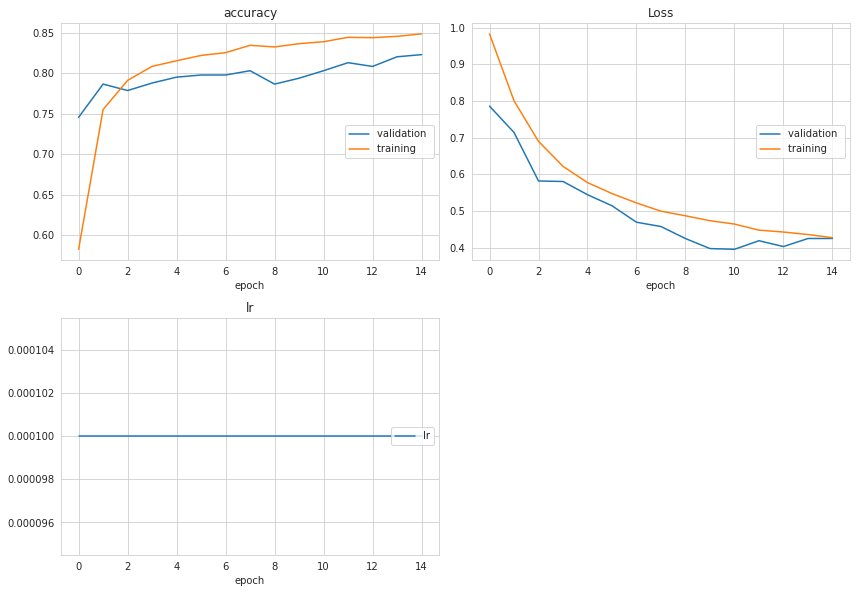

accuracy
	validation       	 (min:    0.746, max:    0.823, cur:    0.823)
	training         	 (min:    0.583, max:    0.849, cur:    0.849)
Loss
	validation       	 (min:    0.396, max:    0.786, cur:    0.425)
	training         	 (min:    0.428, max:    0.983, cur:    0.428)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)

Epoch 00015: val_loss did not improve from 0.39583


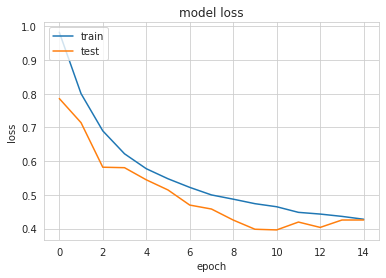

In [21]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras
import os

no_of_epochs  = 15 #10
path="/content/drive/My Drive/covid_runs/xception/xception_balanced_1/"

os.makedirs(path)
json_model = final_Model.to_json()
with open(path+"model.json", "w") as json_file:
  json_file.write(json_model)

reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)
plotlosses = PlotLossesKeras()
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint(filepath=path+'best_weights_xception.hdf5',monitor='val_loss', verbose=1, save_best_only=True)

callbacks = [reduce_learning_rate, plotlosses, checkpoint]


history = final_Model.fit_generator(
    train_set,
    epochs = no_of_epochs,
    validation_data=test_set,
    callbacks=callbacks
)

final_Model.save_weights(path + "last_run.hdf5")

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(path + "accuracy.png")
# summarize history for loss
plt.close()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(path + "loss.png")

In [22]:
model_cloud = load_model_from_cloud("/content/drive/My Drive/covid_runs/xception/xception_balanced_1/model.json", "/content/drive/My Drive/covid_runs/xception/xception_balanced_1/best_weights_xception.hdf5")
model_cloud.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [23]:
predict_datagen = ImageDataGenerator(rescale=1./255)

predict_set = predict_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='image',
    directory="test/",
    y_col='result',
    shuffle=False,
    target_size=(image_width, image_height),
    batch_size = 1,
    class_mode='categorical'
)

filenames = predict_set.filenames
nb_samples = len(filenames)

Found 1510 validated image filenames belonging to 3 classes.


In [24]:
predict = model_cloud.predict_generator(predict_set,steps = nb_samples)

In [25]:
res = []
for i in predict:
  if i[0] > 0.5:
    res.append(0)
  elif i[1] > 0.5:
    res.append(1)
  else:
    res.append(2)

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(predict_set.classes, res, normalize='true')
cr = classification_report(predict_set.classes, res, target_names=['Covid-19','Normal', 'Pneumonia'])
#print(cm)
print(cr)

              precision    recall  f1-score   support

    Covid-19       0.00      0.00      0.00        31
      Normal       0.90      0.71      0.79       885
   Pneumonia       0.65      0.89      0.75       594

    accuracy                           0.76      1510
   macro avg       0.52      0.53      0.51      1510
weighted avg       0.78      0.76      0.76      1510



Text(0, 0.5, 'Ground truth')

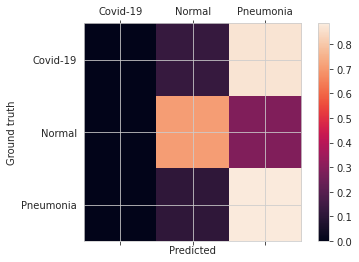

In [26]:
labels = ['Covid-19','Normal', 'Pneumonia']
fig, ax = plt.subplots()
h = ax.matshow(cm)
fig.colorbar(h)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground truth')

####XCeption2

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
import keras
from keras.models import Model
from keras.optimizers import Adam, SGD

image_height = 299
image_width = 299


xception = keras.applications.Xception(weights='imagenet',include_top=False, input_shape = (image_width, image_height, 3))

for layer in xception.layers[:132]:
    layer.trainable = False

new_model = xception.output
new_model = GlobalAveragePooling2D()(new_model)
new_model = Dropout(0.5)(new_model)
new_model = Dense(1024, activation='relu')(new_model)
new_model = Dropout(0.5)(new_model)
new_model = Dense(3, activation="softmax")(new_model)

final_Model = Model(inputs=xception.input, outputs=new_model)




opt = Adam(learning_rate=0.0001)
final_Model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


final_Model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

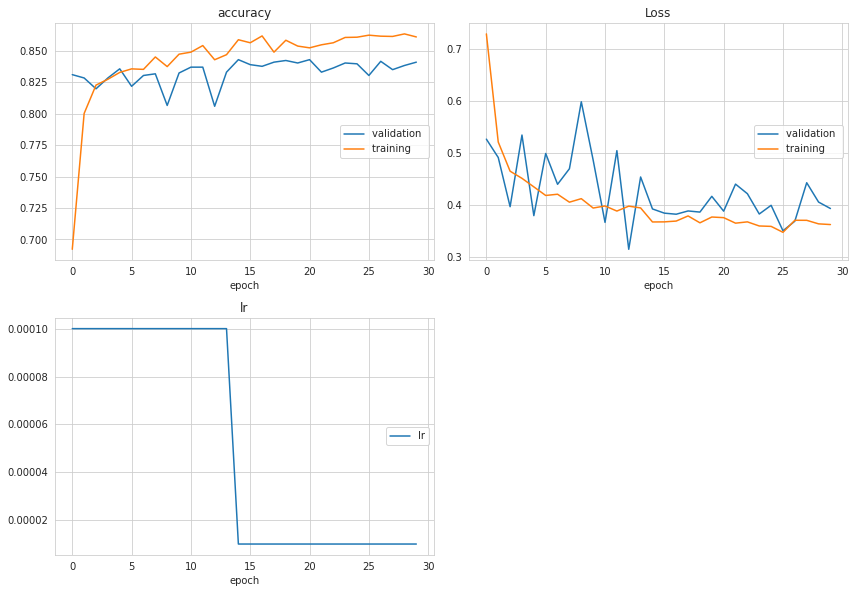

accuracy
	validation       	 (min:    0.806, max:    0.843, cur:    0.841)
	training         	 (min:    0.692, max:    0.864, cur:    0.861)
Loss
	validation       	 (min:    0.315, max:    0.599, cur:    0.393)
	training         	 (min:    0.348, max:    0.729, cur:    0.363)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)

Epoch 00030: val_loss did not improve from 0.31496


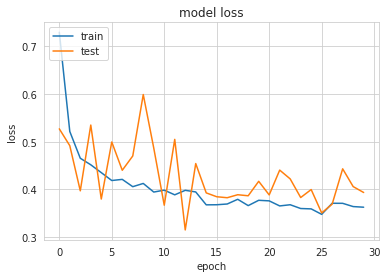

In [28]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras
import os

no_of_epochs  = 30 #10
path="/content/drive/My Drive/covid_runs/xception/xception_balanced_2/"

os.makedirs(path)
json_model = final_Model.to_json()
with open(path+"model.json", "w") as json_file:
  json_file.write(json_model)

reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)
plotlosses = PlotLossesKeras()
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint(filepath=path+'best_weights_xception.hdf5',monitor='val_loss', verbose=1, save_best_only=True)

callbacks = [reduce_learning_rate, plotlosses, checkpoint]


history = final_Model.fit_generator(
    train_set,
    epochs = no_of_epochs,
    validation_data=test_set,
    callbacks=callbacks
)

final_Model.save_weights(path + "last_run.hdf5")

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(path + "accuracy.png")
# summarize history for loss
plt.close()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(path + "loss.png")

In [29]:
## Testing the Model

In [30]:
model_cloud = load_model_from_cloud("/content/drive/My Drive/covid_runs/xception/xception_balanced_2/model.json", "/content/drive/My Drive/covid_runs/xception/xception_balanced_2/best_weights_xception.hdf5")
model_cloud.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [31]:
predict_datagen = ImageDataGenerator(rescale=1./255)

predict_set = predict_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='image',
    directory="test/",
    y_col='result',
    shuffle=False,
    target_size=(image_width, image_height),
    batch_size = 1,
    class_mode='categorical'
)

filenames = predict_set.filenames
nb_samples = len(filenames)

Found 1510 validated image filenames belonging to 3 classes.


In [32]:
predict = model_cloud.predict_generator(predict_set,steps = nb_samples)

In [33]:
res = []
for i in predict:
  if i[0] > 0.5:
    res.append(0)
  elif i[1] > 0.5:
    res.append(1)
  else:
    res.append(2)

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(predict_set.classes, res, normalize='true')
cr = classification_report(predict_set.classes, res, target_names=['Covid-19','Normal', 'Pneumonia'])
#print(cm)
print(cr)

              precision    recall  f1-score   support

    Covid-19       0.78      0.23      0.35        31
      Normal       0.91      0.74      0.81       885
   Pneumonia       0.68      0.89      0.77       594

    accuracy                           0.79      1510
   macro avg       0.79      0.62      0.64      1510
weighted avg       0.81      0.79      0.78      1510



Text(0, 0.5, 'Ground truth')

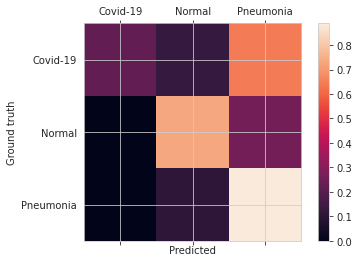

In [34]:
labels = ['Covid-19','Normal', 'Pneumonia']
fig, ax = plt.subplots()
h = ax.matshow(cm)
fig.colorbar(h)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground truth')

#### XCeption 3

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
import keras
from keras.models import Model
from keras.optimizers import Adam, SGD

image_height = 299
image_width = 299


xception = keras.applications.Xception(weights='imagenet',include_top=False, input_shape = (image_width, image_height, 3))

for layer in xception.layers[:132]:
    layer.trainable = False

new_model = xception.output
new_model = GlobalAveragePooling2D()(new_model)
new_model = Dense(128, activation='relu')(new_model)
new_model = Dropout(0.5)(new_model)
new_model = Dense(3, activation="softmax")(new_model)

final_Model = Model(inputs=xception.input, outputs=new_model)




opt = Adam(learning_rate=0.0001)
final_Model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


final_Model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

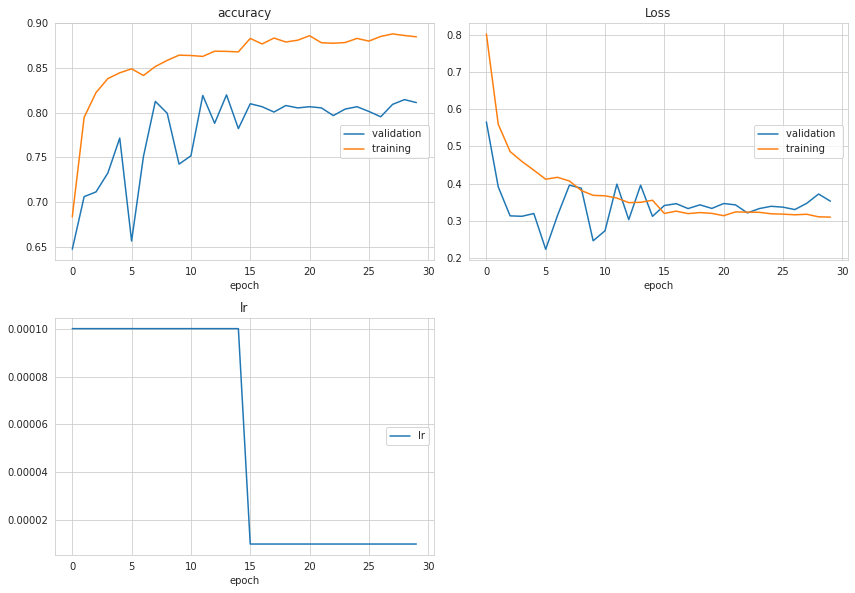

accuracy
	validation       	 (min:    0.647, max:    0.820, cur:    0.811)
	training         	 (min:    0.683, max:    0.888, cur:    0.885)
Loss
	validation       	 (min:    0.223, max:    0.566, cur:    0.352)
	training         	 (min:    0.310, max:    0.803, cur:    0.310)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)

Epoch 00030: val_loss did not improve from 0.22294


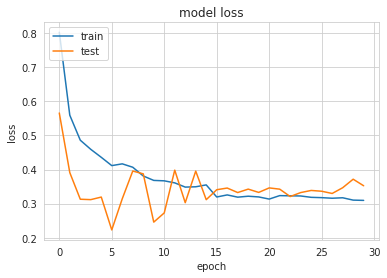

In [36]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras
import os

no_of_epochs  = 30
path="/content/drive/My Drive/covid_runs/xception/xception_balanced_3/"

os.makedirs(path)
json_model = final_Model.to_json()
with open(path+"model.json", "w") as json_file:
  json_file.write(json_model)

reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)
plotlosses = PlotLossesKeras()
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint(filepath=path+'best_weights_xception.hdf5',monitor='val_loss', verbose=1, save_best_only=True)

callbacks = [reduce_learning_rate, plotlosses, checkpoint]


history = final_Model.fit_generator(
    train_set,
    epochs = no_of_epochs,
    validation_data=test_set,
    callbacks=callbacks
)

final_Model.save_weights(path + "last_run.hdf5")

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(path + "accuracy.png")
# summarize history for loss
plt.close()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(path + "loss.png")

In [8]:
model_cloud = load_model_from_cloud("/content/drive/My Drive/covid_runs/xception/xception_balanced_3/model.json", "/content/drive/My Drive/covid_runs/xception/xception_balanced_3/best_weights_xception.hdf5")
model_cloud.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [9]:
predict_datagen = ImageDataGenerator(rescale=1./255)

predict_set = predict_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='image',
    directory="test/",
    y_col='result',
    shuffle=False,
    target_size=(image_width, image_height),
    batch_size = 1,
    class_mode='categorical'
)

filenames = predict_set.filenames
nb_samples = len(filenames)

Found 1510 validated image filenames belonging to 3 classes.


In [10]:
predict = model_cloud.predict_generator(predict_set,steps = nb_samples)

In [14]:
res = []
for i in predict:
  if i[0] > 0.5:
    res.append(0)
  elif i[1] > 0.5:
    res.append(1)
  else:
    res.append(2)

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(predict_set.classes, res, normalize='true')
cr = classification_report(predict_set.classes, res, target_names=['Covid-19','Normal', 'Pneumonia'])
#print(cm)
print(cr)

              precision    recall  f1-score   support

    Covid-19       0.00      0.00      0.00        31
      Normal       0.91      0.45      0.60       885
   Pneumonia       0.52      0.94      0.67       594

    accuracy                           0.63      1510
   macro avg       0.48      0.46      0.42      1510
weighted avg       0.74      0.63      0.61      1510



Text(0, 0.5, 'Ground truth')

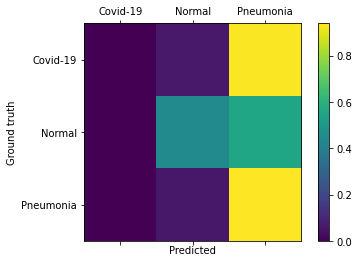

In [15]:
labels = ['Covid-19','Normal', 'Pneumonia']
fig, ax = plt.subplots()
h = ax.matshow(cm)
fig.colorbar(h)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground truth')